In [1]:
import os
import torch
import torch.nn as nn
import torchaudio

In [2]:
from utils.visual import plot_alignment, plot_line
from utils.dataset import get_audio, parser_line

In [3]:
def get_transcriptions(path):
    with open(path) as f:
        lines = f.read().split('\n')
        return lines

In [4]:
path = './data/segments/'

In [5]:
lines = get_transcriptions(path+'train.txt')
if (lines[-1]==''):
    lines = lines[:-1]
len(lines)

3550

In [6]:
phoneme_set = set()
note_set = set()
for line in lines:
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)
    phoneme_set.update(set(phoneme))
    note_set.update(set(note))

In [7]:
phoneme_set, note_set

({'AP',
  'SP',
  'a',
  'ai',
  'an',
  'ang',
  'ao',
  'b',
  'c',
  'ch',
  'd',
  'e',
  'ei',
  'en',
  'eng',
  'er',
  'f',
  'g',
  'h',
  'i',
  'ia',
  'ian',
  'iang',
  'iao',
  'ie',
  'in',
  'ing',
  'iong',
  'iu',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'ong',
  'ou',
  'p',
  'q',
  'r',
  's',
  'sh',
  't',
  'u',
  'ua',
  'uai',
  'uan',
  'uang',
  'ui',
  'un',
  'uo',
  'v',
  'van',
  've',
  'vn',
  'w',
  'x',
  'y',
  'z',
  'zh'},
 {'A#3/Bb3',
  'A#4/Bb4',
  'A3',
  'A4',
  'A5',
  'B3',
  'B4',
  'C#2/Db2',
  'C#3/Db3',
  'C#4/Db4',
  'C#5/Db5',
  'C3',
  'C4',
  'C5',
  'D#3/Eb3',
  'D#4/Eb4',
  'D#5/Eb5',
  'D2',
  'D3',
  'D4',
  'D5',
  'E3',
  'E4',
  'E5',
  'F#3/Gb3',
  'F#4/Gb4',
  'F#5/Gb5',
  'F3',
  'F4',
  'F5',
  'G#3/Ab3',
  'G#4/Ab4',
  'G3',
  'G4',
  'rest'})

In [8]:
line = lines[4]
line

'2001000005|面对浩瀚的星海我们微小得像尘埃|m ian d ui h ao h an an d e x ing h ai ai ai AP w o m en w ei x iao d e x iang ch en ai ai ai SP|C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 E4 D#4/Eb4 D#4/Eb4 E4 E4 G#4/Ab4 G#4/Ab4 A4 G#4/Ab4 rest C#4/Db4 C#4/Db4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 E4 E4 E4 E4 G#4/Ab4 A4 G#4/Ab4 rest|0.196990 0.196990 0.102120 0.102120 0.304680 0.304680 0.096780 0.096780 0.100220 0.150010 0.150010 0.361460 0.361460 0.221070 0.221070 0.183240 0.478670 0.384620 0.106510 0.106510 0.143020 0.143020 0.169480 0.169480 0.224180 0.224180 0.089360 0.089360 0.414460 0.414460 0.378050 0.378050 0.162790 0.207380 0.317260 0.297040|0.02765 0.16934 0.01874 0.08338 0.0821 0.22258 0.0693 0.02748 0.10022 0.07137 0.07864 0.12471 0.23675 0.12356 0.09751 0.18324 0.47867 0.38462 0.0405 0.06601 0.08303 0.05999 0.04687 0.12261 0.09778 0.1264 0.02321 0.06615 0.11958 0.29488 0.06723 0.31082 0.16279 0.20738 0.31726 0.29704|0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

In [9]:
id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)

In [10]:
waveform = get_audio(id, path)
waveform

tensor([[ 0.0016,  0.0027,  0.0027,  ..., -0.0004, -0.0002, -0.0001]])

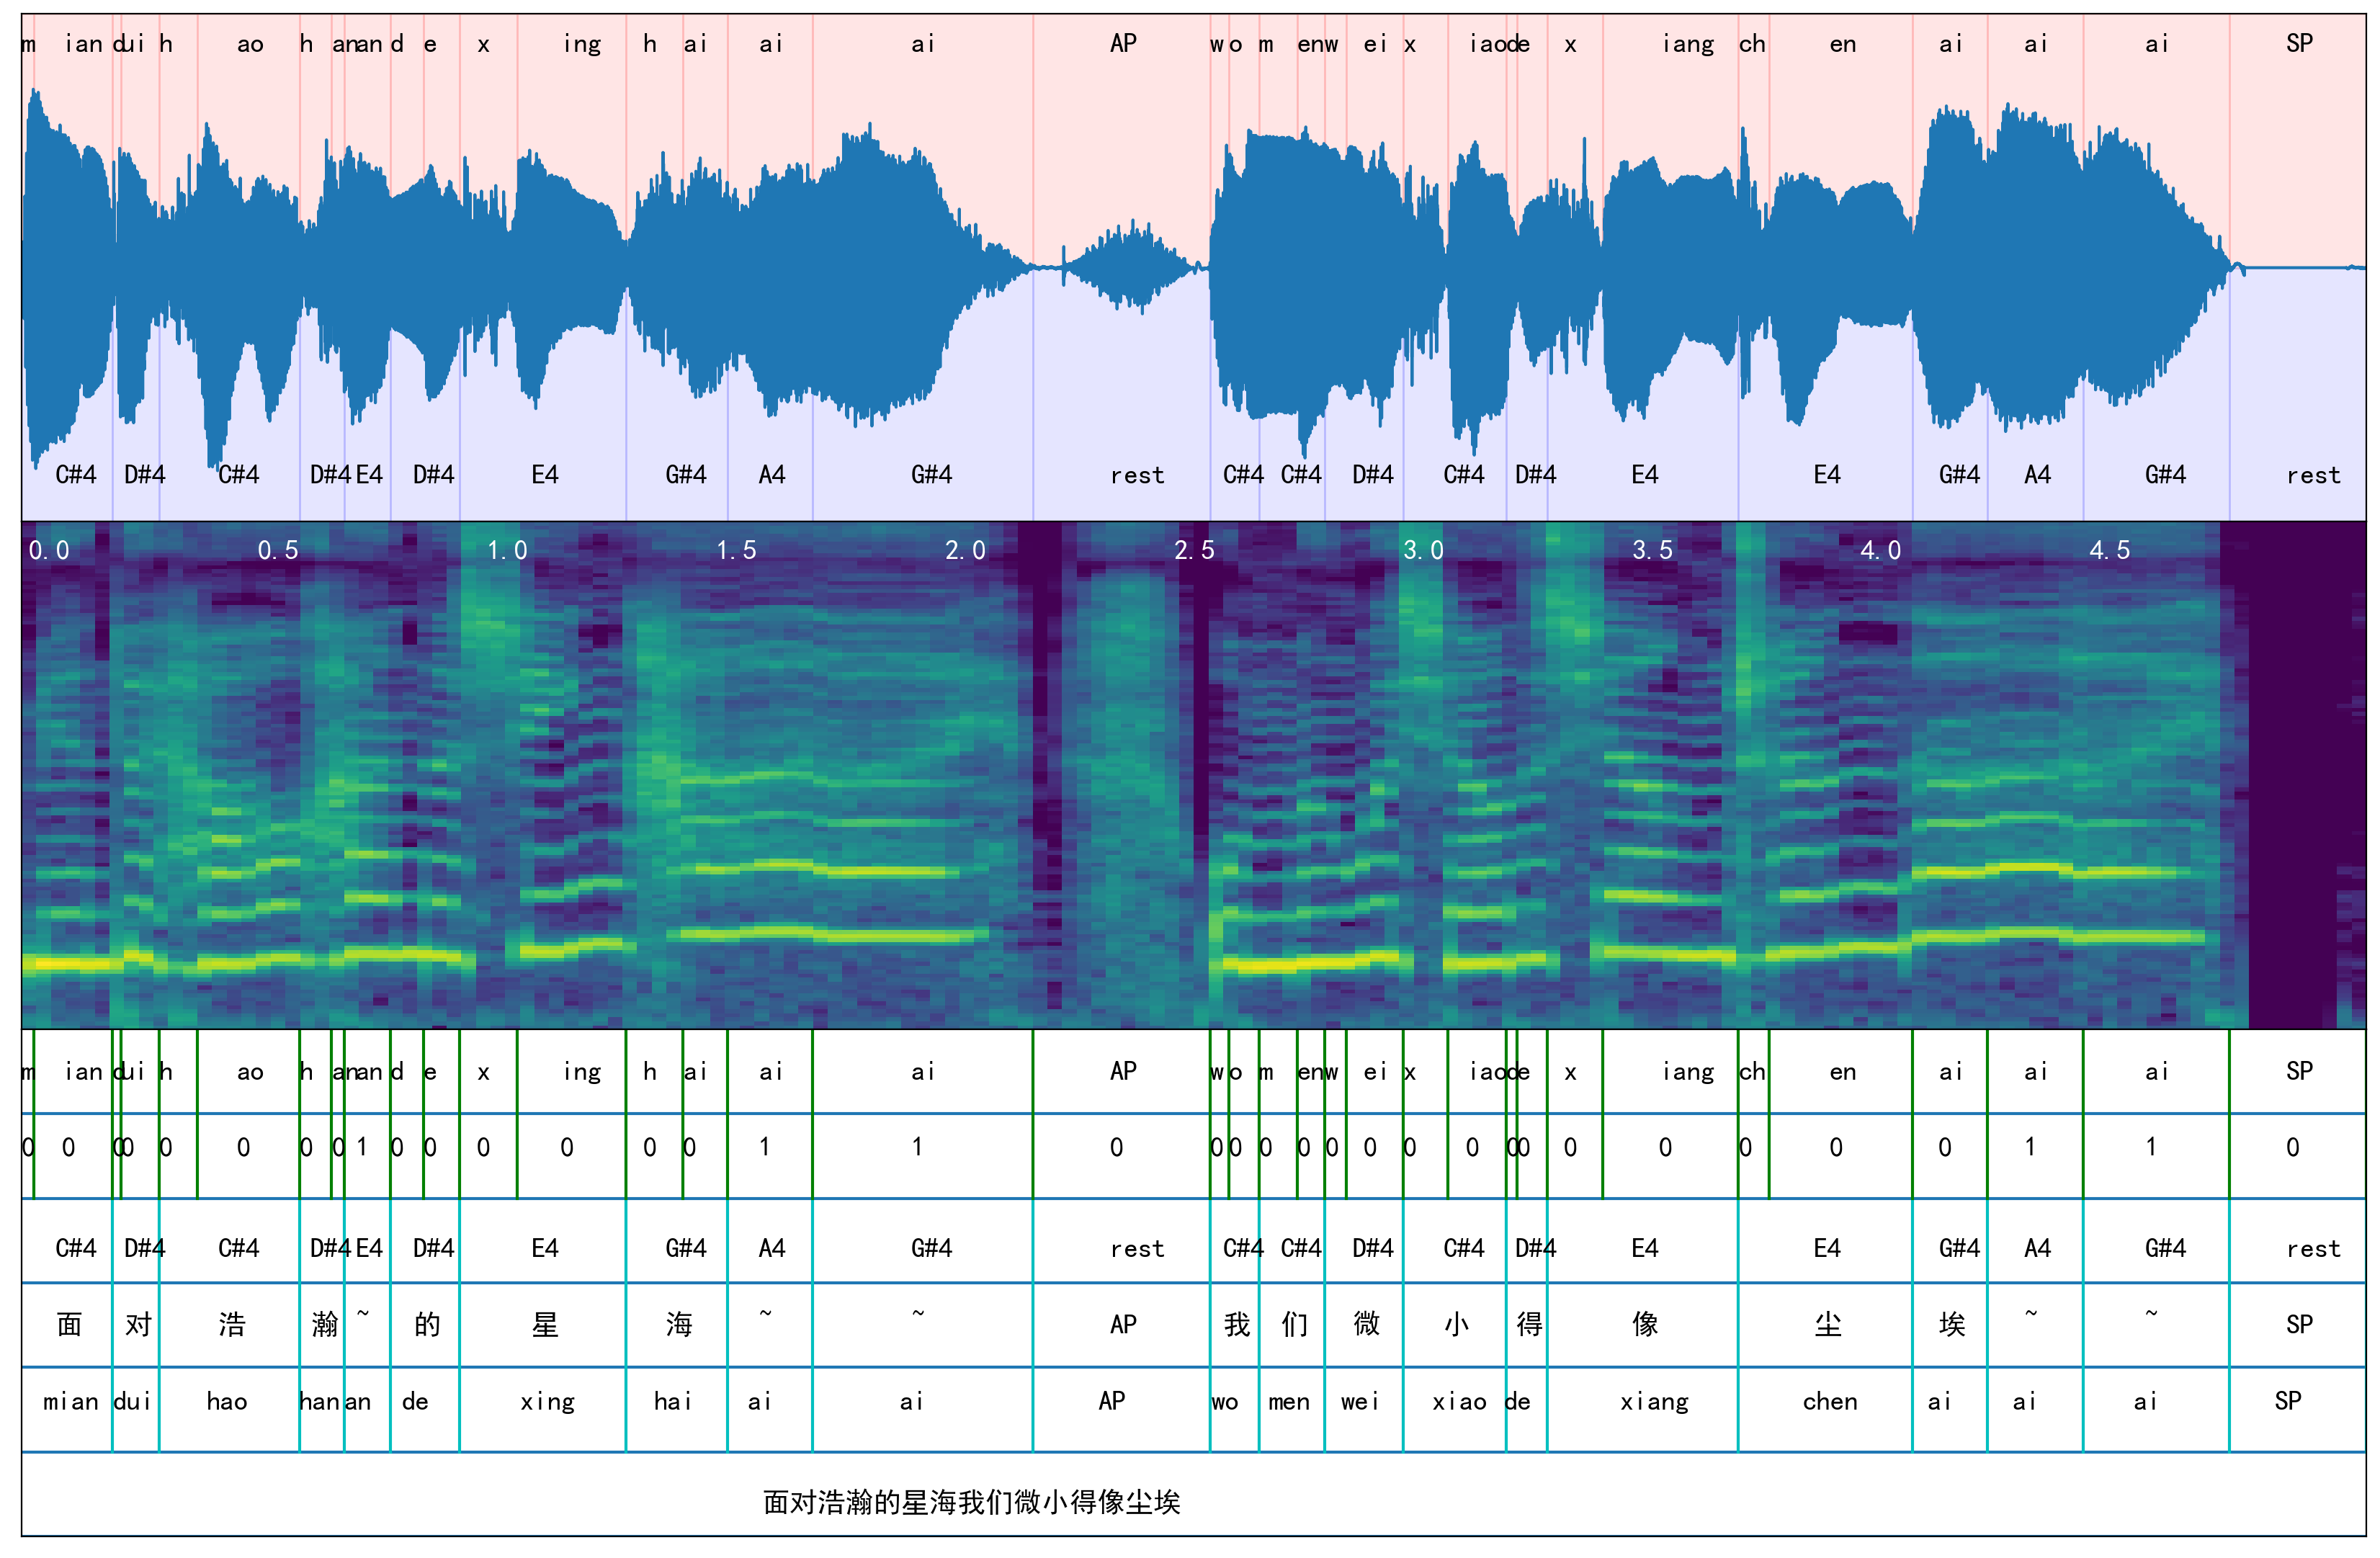

In [16]:
plot_line(lines[4], path)

# 带有元音辅音+音调的音素级检测



In [13]:
import pyaudio, struct
def play(waveform, gain = 0.9):
    assert len(waveform.shape) == 1
    waveform = (waveform*gain).to(torch.int32).tolist()
    p = pyaudio.PyAudio()
    stream = p.open(
        format = pyaudio.paInt16,  
        channels = 1, 
        rate = 16000,
        input = False, 
        output = True,
        frames_per_buffer = 128)
    binary_data = struct.pack('h' * len(waveform), *waveform)   # 'h' for 16 bits
    stream.write(binary_data)
    stream.stop_stream()
    stream.close()
    p.terminate()

# play(waveform[0])

In [15]:
phoneme_duration

def play_phoneme(i, phoneme_duration, waveform):
    assert i < len(phoneme_duration)
    start = int(sum(phoneme_duration[:i-1])*16000)
    end = int(sum(phoneme_duration[:i])*16000)
    phoneme_cut = waveform[start:end]
    play(phoneme_cut)

# play_phoneme(1, phoneme_duration, waveform[0])
    